# Conditional GAN (cGAN)

This notebook follows the tutorial from the website machine learning mastery:

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

This kind of GAN can be conditioned on the input image class which allows for a generator that can generate samples from each class by conditioning the generation. This both allows for more flexibility in the training process and adds more options for generation than simply sampling random points from the latent space. The implementation here follows from the original cGAN paper where the image labels are added as a one-hot-encoded vector that is combined with the input in both the discriminator and generator and then emebeded along with the other features, this has the effect of conditioning either the generator or discriminator on the class label.

original paper:
https://arxiv.org/pdf/1411.1784.pdf


## Loading the data
We will be using the CIFAR10 dataset again here. we can download it using keras


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets.cifar10 import load_data



In [0]:
(x_train,y_train),(X_test,y_test) = load_data()

## Making the discriminator

Since we are building a conditional gan, we will need two inputs, one for the image itself and another for the label vector that we will use to condition the generator and discriminator. 

Usually we would have used the Sequential API in order to build our model but we can't do that here as we have two different input which we won't merge immediatly. We first need to pass the label vector through an embeding layer before adding it to the convolutions down the line

This here describes how to use the Funtional API which we will make use of for building our two models:

https://machinelearningmastery.com/keras-functional-api-deep-learning/



In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2DTranspose
from keras.optimizers import Adam



# define the standalone discriminator model
def make_discriminator(in_shape=(32,32,3), n_classes=10):
    
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1] * 3
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 3))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


def define_generator(latent_dim=100, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes =  8 * 8 * 3
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((8, 8, 3))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
 
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    print(g_model.input)
    print(d_model.input)
    
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = trainX
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [0]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    train_lat_points,_ = generate_latent_points(100,9)
    train_labels =  np.arange(9)
    train_images = []

    gan_loss = []
    disc_loss = []

    # manually enumerate epochs
    for i in range(n_epochs):
        print("starting epoch",i+1)
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

            if j % 10 == 0:
                #save images
                imgs = g_model.predict([train_lat_points,train_labels])
                train_images.append(imgs)

    # save the generator model
    g_model.save('cgan_generator.h5')
    
    return train_images

disc = make_discriminator()
gen = define_generator()

gan = define_gan(gen,disc)

dataset = load_real_samples()

train_images = train(gen,disc,gan,dataset,100,100)

[<tf.Tensor 'input_94:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'input_93:0' shape=(?, 1) dtype=float32>]
[<tf.Tensor 'input_92:0' shape=(?, 32, 32, 3) dtype=float32>, <tf.Tensor 'input_91:0' shape=(?, 1) dtype=float32>]
starting epoch 1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [65]:
train_images.shape

AttributeError: ignored

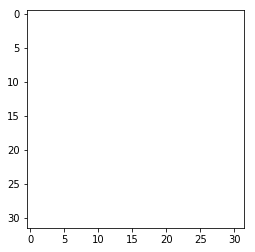

In [66]:
from matplotlib import animation

ims = []
fig = plt.figure()
ax1 = fig.add_subplot()
ax2 = fig.add_subplot()
"""
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
ax.set_xticks([])
ax.set_yticks([])
"""

for train_ims in train_images:

    train_ims = (train_ims +1) /2.0

    im_1 = plt.imshow(train_ims[5,:,:],vmin=0, vmax=1, animated=True) #add first image for test
    
    ims.append([im_1])
    #plt.pause(0.1) 

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.ArtistAnimation(fig,ims)
anim.save("test_gif_3.mp4", writer= writer)

(3, 3)


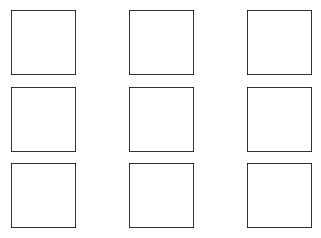

In [68]:
fig,axs = plt.subplots(3,3)

print(axs.shape)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

images = []

#iterate ove images
for imgs in train_images:
    ims = [] 
    imgs = (imgs +1) /2.0

    for i,img in enumerate(imgs):
        
        line = i%3
        col = int(i/3)
        ims.append(axs[line,col].imshow(img[:,:],vmin=0, vmax=1, animated=True))
    
    images.append(ims)

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.ArtistAnimation(fig,images)
anim.save("train_grid.mp4", writer= writer)
